## Pré-processamento das imagens

Vamos utilizar o ImageDataGenerator do Keras para ajustar a escala das imagens, normaliza-las e efetuar um aumento na variabilidade dos dados. Para isso, utilizamos os parâmetros:

+ rescale = 1./255: esse parâmetro normaliza os valores dos pixels das imagens para o intervalo [0, 1], reduzindo a escala numérica dos pixels que usalmente está no intervalo [0, 255] evitando assim problemas numéricos;

+ rotation_range = 40: aplica uma rotação aleatória nas imagens de até 40 graus no sentido horário ou anti-horário aumentando a variabilidade do dataset pois uma foto de gato ou cachorro pode ser tirada de diferentes ângulos;

+ width_shift_range = 0.2: desloca a imagem aleatoriamente na horizontal em até 20% da largura da imagem, simulando possíveis variações na posição do cachorro ou gato na foto;

+ height_shift_range = 0.2: desloca a imagem aleatoriamente na vertical em até 20% da altura da imagem, simulando possíveis variações na posição do cachorro ou gato na foto;

+ shear_range = 0.2: distorce a imagem, simulando possíveis distorções devido ao ângulo ou lente da câmera;

+ zoom_range = 0.2: da um zoom aleatório na imagem para dentro ou para fora em até 20%, ajudando o modelo a identificar diferentes escalas;

+ horizontal_flip = True: inverte horizontalmente a imagem;

+ fill_mode = 'nearest': preenche os pixels que podem faltar após algumas transformações como rotações ou deslocamento para o pixel mais próximo.

Esse método não modifica as imagens originais, apenas aplica as transformações durante o treinamento. Como as transformações são aleatórias, a cada vez que o modelo for treinado, verá as imagens ligeiramente diferente evitando problemas de overfitting.



In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os 

#definindo os diretórios 
base_dir       = '' #caminho do dataset que possui todas as imagens
train_dir      = os.path.join(base_dir, 'train') #caminho do dataset de treinamento
test_dir = os.path.join(base_dir, 'test') #caminho do dataset de validação 

#para realizar o train_datagen
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    #brightness_range = [0.8, 1.2], #variação do brilho 
    #channel_shift_range = 50.0 #variação de canais de cor
)

#o conjunto de validação é apenas redimensionado e normalizado 
test_datagen = ImageDataGenerator(rescale = 1./255)

#gerando os dados que serão utilizados durante o treinamento 
train_generator = train_datagen.flow_from_directory(
    train_dir, #diretório com as imagens de treinamento 
    target_size = (150, 150), #redimensiona as imagens para 150x150 pixels,
    batch_size = 32, #número de imagens que serão utilizadas por batch
    class_mode = 'binary' #modo de classificação binária (cães vs gatos)
)

#acessa os dados que serão utilizados para validação
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary'
)



Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Construção do modelo 

Vamos criar uma Convolutional Neural Network (CNN). A CNN é uma rede neural projetada para processar dados de imagens que será configurada com as seguintes importações:

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

### Funcionamento

Com as imagens já pré-processadas, as utilizamos como **input** para o modelo que executa uma operação de **convolução** e com isso gera um feature map para cada uma das 32 features detectadas. Em seguida, o **subsampling** reduz as dimensões de cada um dos feature map gerados, mantendo as informações mais importantes e reduzindo o ruído. Esse processo contínua até que tenhamos o **output**.

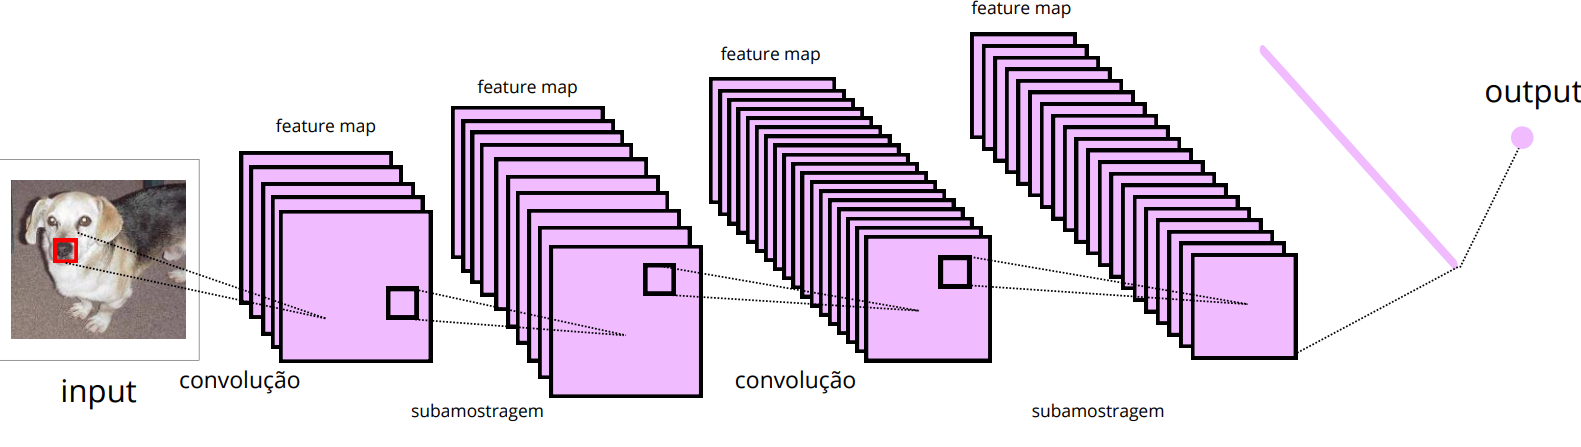

In [3]:
from IPython.display import Image, display

display(Image("sequential_keras.png", width=900, height=300))  # Ajuste conforme necessário


### O que é a operação de convolução?

Imagine que os nossos dados não normalizados sejam compostos por uma imagem pequena, representada por uma matriz 5x5 do tipo:

$$
\begin{bmatrix}
1 & 2 & 3 & 0 & 1 \\
4 & 5 & 6 & 1 & 3\\
7 & 8 & 9 & 2 & 3 \\
3 & 2 & 1 & 5 & 4 \\
0 & 1 & 2 & 4 & 6
\end{bmatrix}
$$

Nós também temos um **kernel**, que é uma matriz pequena composta por pesos inicialmente aleatórios. Durante o treinamento, a rede ajusta esses valores de entrada do kernel para detectar padrões úteis (**features**), como no nosso caso, o focinho de um cachorro. Assim, o que o kernel faz é deslizar sobre a imagem e calcular o produto escalar com as entradas para gerar um **feature map**. 

$$
\begin{bmatrix}
1 & 2 & 3 \\
7 & 5 & 3 \\
2 & 1 & 0  
\end{bmatrix}
$$

No nosso exemplo, este kernel realiza o seguinte: 

1. Seleciona uma matriz de entrada 3x3 da imagem:

$$
\begin{bmatrix}
\color{red}{1} & \color{red}{2} & \color{red}{3} & 0 & 1 \\
\color{red}{4} & \color{red}{5} & \color{red}{6} & 1 & 3\\
\color{red}{7} & \color{red}{8} & \color{red}{9} & 2 & 3 \\
3 & 2 & 1 & 5 & 4 \\
0 & 1 & 2 & 4 & 6
\end{bmatrix}
$$

2. Multiplica elemento a elemento pelo kernel

$$
\begin{bmatrix}
(1 \times 1) & (2 \times 2) & (3 \times 3) \\
(4 \times 7) & (5 \times 5) & (6 \times 3) \\
(7 \times 2) & (8 \times 1) & (9 \times 0)  
\end{bmatrix}
$$

3. Calcula a soma dos elementos:

(1 + 4 + 9) + (28 + 25 + 18) + (14 + 8 + 0) = 107

+ O valor resultante, 107, é colocado no feature map na posição correspondente.

+ O kernel é movido para a próxima posição na imagem e repetimos o processo.

Depois de aplicar o kernel sobre toda a imagem, obtemos um feature map reduzido, que destaca uma feature específica.

### Como funciona o subsampling?

Agora que os feature maps estão gerados, reduzimos sua dimensionalidade para evitar problemas de ruído e reduzir o custo computacional, selecionando as informações mais importantes. Para isso, utilizamos operações como:

1. Max Pooling:

Dividimos a imagem em pequenas regiões e pegamos apenas o valor máximo de cada região, mantendo os valores mais representativos. Como exemplo, vamos utilizar a nossa matriz fictícia:

$$
\begin{bmatrix}
1 & 2 & 3 & 0 & 1 \\
4 & 5 & 6 & 1 & 3\\
7 & 8 & 9 & 2 & 3 \\
3 & 2 & 1 & 5 & 4 \\
0 & 1 & 2 & 4 & 6
\end{bmatrix}
$$

Agora vamos aplicar um Max Pooling 2x2, onde temos como resultado:

$$
\begin{bmatrix}
6 & 6 \\
9 & 9
\end{bmatrix}
$$

2. Average Pooling

Essa operação não procura pelo valor máximo em cada região mas sim calcula a média dos valores, podendo perder detalhes importantes nesse processo.

$$
\begin{bmatrix}
3 & 2.5 \\
4.5 & 4
\end{bmatrix}
$$

### Visualizando o processo

Para visualizarmos a aplicação do kernel e o processo de geração do feature map, vamos plotar um exemplo visual do nosso problema. Para isso, inicialmente carregamos uma imagem exemplo:

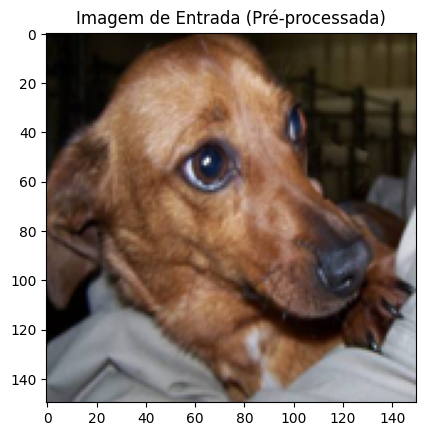

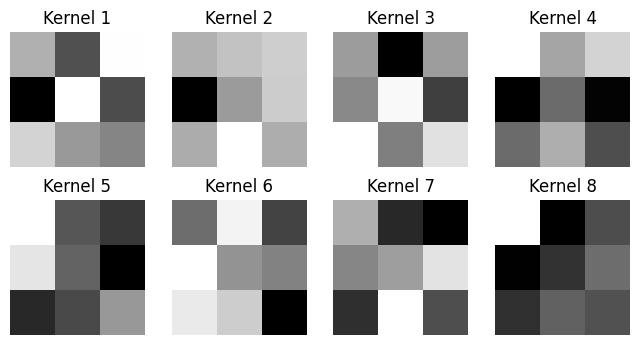

1/1 [==============================] - 0s 54ms/step


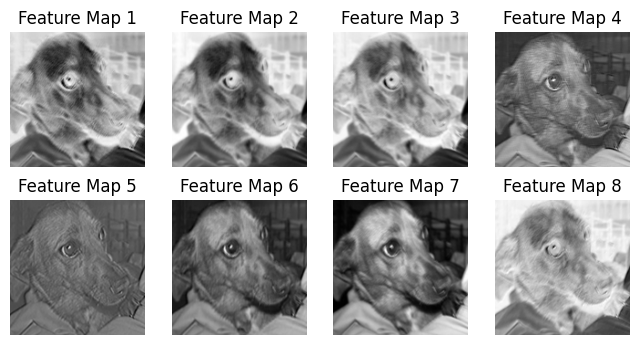

In [4]:
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

#carrega a imagem 
caminho_da_imagem = 'dog.509.jpg' #caminho da imagem 
imagem = Image.open(caminho_da_imagem)

#pré-processa a imagem:  e normaliza os pixels no intervalo en
imagem = imagem.resize((150, 150)).convert('RGB')  #garante que ela tenha tamanho 150 x 150 e três canais RGB
imagem = np.array(imagem)  #converte a imagem para um array 
imagem = imagem / 255.0  #normaliza o valor dos pixels para um intervalo entre 0 e 1

#exibe a imagem carregada 
plt.imshow(imagem)
plt.title('Imagem de Entrada (Pré-processada)')
plt.show()

#gera o modelo que estamos utilizando 
model_ = Sequential()
model_.add(Conv2D(filters=32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), 
                  padding='valid', 
                  input_shape=(150, 150, 3)))

#expande as dimensões da imagem para o formato (1, 150, 150, 3)
imagem = np.expand_dims(imagem, axis=0)

#visualiza os kernels
kernels, biases = model_.layers[0].get_weights()
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())  #normaliza para visualização

plt.figure(figsize=(8, 4))
for i in range(min(8, kernels.shape[-1])):  #visualiza os 8 primeiros kernels
    plt.subplot(2, 4, i + 1)
    plt.imshow(kernels[:, :, :, i].mean(axis=-1), cmap='gray')  #média dos canais RGB
    plt.title(f'Kernel {i + 1}')
    plt.axis('off')
plt.show()

#gera o feature map 
feature_map = model_.predict(imagem)
feature_map = np.squeeze(feature_map, axis=0)  #remove a dimensão do batch

#visualiza alguns dos feature maps gerados
num_filters = feature_map.shape[-1]  #número de feature maps
plt.figure(figsize=(8, 4))
for i in range(min(8, num_filters)):  #visualiza os 16 primeiros feature maps
    plt.subplot(2, 4, i + 1)
    plt.imshow(feature_map[:, :, i], cmap='gray')
    plt.title(f'Feature Map {i + 1}')
    plt.axis('off')
plt.show()



Agora que já entendemos o funcionamento do modelo, vamos configura-lo para podermos treina-lo:

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import InputLayer

model = tf.keras.Sequential([

    #Primeira camada convolucional: 
        #Aplica 32 kernels de tamanho 3x3 na imagem de entrada;
        #Define o formato da entrada como sendo imagens de 150x150 pixels com 3 canais de cor RGB
        #activation = 'relu': Usa a função de ativação ReLU (Rectified Linear Unit) que introduz não-linearidade ao modelo
        #Saída: Após a convolução, a imagem terá 32 feature maps
        #primeira camada convolucional

    InputLayer(input_shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), #reduz a dimensionalidade da imagem com uma matriz 2x2 selecionando o valor máximo em cada uma dessas janelas

    #segunda camada convolucional: aplica 64 kernels de tamanho 3x3
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    #terceira camada convolucional: aplica 128 kernels de tamanho 3x3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    #quarta camada convolucional: aplica 128 kernels de tamanho 3x3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    #achata a saída das camadas convolucionais em um vetor unidimensional
    Flatten(),

    #conecta todos os neurônios da camada anterior a 512 neurônios, utilizando a função ReLU
    Dense(512, activation='relu'),

    #desliga aleatoriamente 50% dos neurônios durante o treinamento, evitando overfitting e tornando o modelo mais geral
    Dropout(0.5),
#
    ##Dropout(0.3),
    ##camada de saída: produz uma única saída para decisão (cão ou gato)
    Dense(1, activation='sigmoid')
])

#compilando o modelo 
model.compile(
    optimizer='adam', #usa o otimizador Adam
    loss='binary_crossentropy', #define a função de perda como binary_crossentropy
    metrics=['accuracy'] #utiliza como métrica a acurácia
)

#resumo do modelo 
model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)    

### Treinando o modelo 

Para treinar o modelo, vamos utilizar o nosso gerador de dados (train_generator), que nos fornece os batches de imagens durante o treinamento. Além disso, vamos inserir o conceito de **epoch**, fundamental para entender como o modelo aprende. 

### O que é uma epoch?

Uma epoch é uma passagem completa pelo conjunto de dados de treinamento, ou seja, **durante uma epoch o modelo vê todas as imagens do dataset de treinamento uma vez.** O modelo ajusta seus parâmetros a cada batch processado, e uma única epoch geralmente não é suficiente para o que o modelo aprenda suficientemente bem. Por isso, repetimos o processo por várias epochs.

+ Obs: É necessário ter precaução quanto ao número de epochs: se for muito pequeno, o modelo não aprende o suficiente (**underfitting**), se for muito alto, o modelo pode memorizar os dados de treinamento ao invés de aprender (**overfitting**).

### O que é o batch_size?

O batch_size é o número de imagens processadas antes qe o modelo atualize seus pesos. No nosso, caso, o batch_size = 32, ou seja, o modelo processa 32 imagens por vez, calcula o erro e então ajusta seus pesos. 

Noss dataset de treinamento tem 20.000 imagens, então o número de batches por epoch é:

$$
\text{Número de batches por epoch} = \frac{\text{Número total de imagens}}{\text{Batch size}} = \frac{20.000}{32} = 625
$$

Assim, em uma epoch, o modelo processa 625 batches de 32 imagens cada.

### Early Stopping - escolhendo o número de batches

Essa técnica monitora a progressão da métrica val_loss para avaliar a perda no conjunto de validação. Se os resultados não melhorarem a medida que as epochs passam ou continuarem o mesmo, o sistema é restaurado para o melhor resultado. **Patience** é um parâmetro que define o número de épocas sem melhoria antes de parar.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

#configuração do Early Stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss', #monitora  aperda no conjunto de validação
    patience = 5, #espera 5 épocas sem melhoria
    restore_best_weights = True #restaure os melhores pesos
)

#treinamento do modelo com early Stopping
history = model.fit(
    train_generator,
    steps_per_epoch = 625, #número de batches por época
    epochs = 50, 
    validation_data = test_generator,
    validation_steps = 50, #número de batches para validação
    callbacks = [early_stopping] #adiciona o early_stopping
)

Epoch 1/50


625/625 [==============================] - 223s 354ms/step - loss: 0.6854 - accuracy: 0.5535 - val_loss: 0.6857 - val_accuracy: 0.5587
Epoch 2/50
625/625 [==============================] - 105s 168ms/step - loss: 0.6614 - accuracy: 0.6043 - val_loss: 0.6366 - val_accuracy: 0.6450
Epoch 3/50
625/625 [==============================] - 105s 168ms/step - loss: 0.6122 - accuracy: 0.6637 - val_loss: 0.5488 - val_accuracy: 0.7244
Epoch 4/50
625/625 [==============================] - 105s 168ms/step - loss: 0.5744 - accuracy: 0.6974 - val_loss: 0.5769 - val_accuracy: 0.7175
Epoch 5/50
625/625 [==============================] - 103s 165ms/step - loss: 0.5530 - accuracy: 0.7179 - val_loss: 0.5265 - val_accuracy: 0.7444
Epoch 6/50
625/625 [==============================] - 102s 163ms/step - loss: 0.5242 - accuracy: 0.7419 - val_loss: 0.4476 - val_accuracy: 0.7906
Epoch 7/50
625/625 [==============================] - 102s 163ms/step - loss: 0.5018 - accuracy: 0.7574 - val_loss: 0.4204

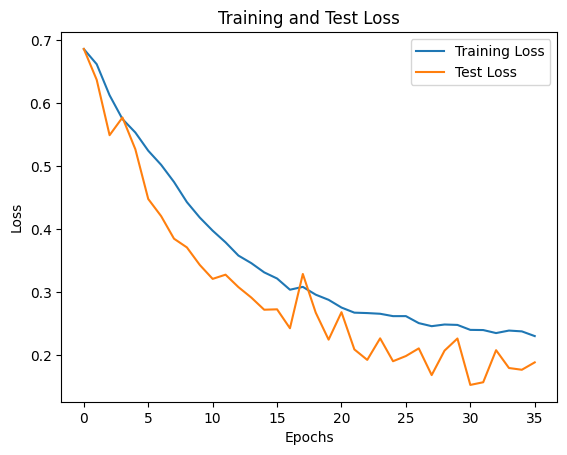

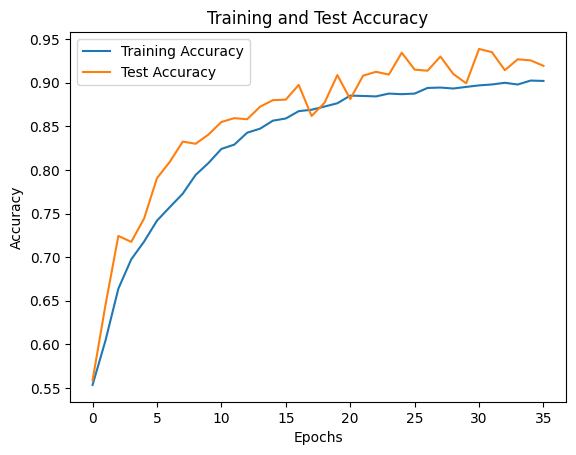

In [7]:
#para visualização do desempenho
import matplotlib.pyplot as plt

#plot da perda 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plot da acurácia
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.models import load_model

model.save('meu_modelo.h5')

c:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

#carrega o modelo salvo
modelo_carregado = load_model('meu_modelo.h5')

In [ ]:
#avalia o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

print(f"Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%")
print(f"Perda no conjunto de teste: {test_loss:.4f}")

157/157 [==============================] - 7s 43ms/step - loss: 0.1696 - accuracy: 0.9300
Acurácia no conjunto de teste: 93.00%
Perda no conjunto de teste: 0.1696
